In [1]:
import paddle
from paddle.nn import Linear,ReLU
import paddle.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
datafile = "./data/housing.data"
data = np.fromfile(datafile, sep=" ")

# 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
feature_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV",
]
feature_num = len(feature_names)

# 将原始数据进行Reshape，变成[N, 14]这样的形状
data = data.reshape([data.shape[0] // feature_num, feature_num])

# 将原数据集拆分成训练集和测试集
# 这里使用80%的数据做训练，20%的数据做测试
# 测试集和训练集必须是没有交集的
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]

# 计算训练集的最大值，最小值，平均值
maximums, minimums, avgs = (
    training_data.max(axis=0),
    training_data.min(axis=0),
    training_data.sum(axis=0) / training_data.shape[0],
)

# 记录数据的归一化参数，在预测时对数据做归一化
max_values = maximums
min_values = minimums
avg_values = avgs

# 对数据进行归一化处理
for i in range(feature_num):
    # print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

# 训练集和测试集的划分比例
training_data = data[:offset]
test_data = data[offset:]
print(training_data.shape, test_data.shape)

(404, 14) (102, 14)


C:\Users\SongWood\App\anaconda\envs\test\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
class Regressor(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        self.fc = Linear(in_features=13, out_features=20)
        self.fc2 = Linear(in_features=20, out_features=1)
        self.act = ReLU()
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc(inputs)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [4]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        x = x.astype(np.float32)
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        y = y.astype(np.float32)
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)

        # 前向计算
        predicts = model(house_features)

        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        if iter_id%20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))

        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

epoch: 0, iter: 0, loss is: [0.7663299]
epoch: 0, iter: 20, loss is: [0.09859718]
epoch: 0, iter: 40, loss is: [0.04648387]
epoch: 1, iter: 0, loss is: [0.02603148]
epoch: 1, iter: 20, loss is: [0.13479038]
epoch: 1, iter: 40, loss is: [0.05084109]
epoch: 2, iter: 0, loss is: [0.05533341]
epoch: 2, iter: 20, loss is: [0.02567704]
epoch: 2, iter: 40, loss is: [0.11559288]
epoch: 3, iter: 0, loss is: [0.0325999]
epoch: 3, iter: 20, loss is: [0.0307189]
epoch: 3, iter: 40, loss is: [0.02846506]
epoch: 4, iter: 0, loss is: [0.05051677]
epoch: 4, iter: 20, loss is: [0.03191433]
epoch: 4, iter: 40, loss is: [0.07885741]
epoch: 5, iter: 0, loss is: [0.04289191]
epoch: 5, iter: 20, loss is: [0.0963852]
epoch: 5, iter: 40, loss is: [0.00875652]
epoch: 6, iter: 0, loss is: [0.0792899]
epoch: 6, iter: 20, loss is: [0.02040826]
epoch: 6, iter: 40, loss is: [0.02334964]
epoch: 7, iter: 0, loss is: [0.02049701]
epoch: 7, iter: 20, loss is: [0.04250484]
epoch: 7, iter: 40, loss is: [0.00444912]
epoch

In [5]:
one_data, label = test_data[:, :-1], test_data[:, -1]
one_data = one_data.reshape([test_data.shape[0],-1])
one_data = one_data.astype(np.float32)

In [6]:
model = Regressor()
# 参数为保存模型参数的文件地址
model_dict = paddle.load('LR_model.pdparams')
model.load_dict(model_dict)
model.eval()

# 参数为数据集的文件地址
# 将数据转为动态图的variable格式 
one_data = paddle.to_tensor(one_data)
predict = model(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict.numpy(), label))

Inference result is [[31.553558]
 [29.849344]
 [32.601913]
 [35.04631 ]
 [38.421616]
 [36.27618 ]
 [22.081894]
 [33.824486]
 [34.30266 ]
 [32.829018]
 [31.41888 ]
 [34.161793]
 [33.539753]
 [31.530561]
 [22.672815]
 [31.202747]
 [35.516968]
 [35.20641 ]
 [34.67768 ]
 [32.892807]
 [29.25441 ]
 [31.264042]
 [28.07789 ]
 [23.691881]
 [32.67667 ]
 [34.10781 ]
 [33.27093 ]
 [34.70147 ]
 [31.32558 ]
 [32.090378]
 [30.735437]
 [33.724712]
 [29.580973]
 [32.140606]
 [34.996147]
 [35.112026]
 [33.36306 ]
 [35.92859 ]
 [36.053226]
 [36.145855]
 [34.79568 ]
 [32.633324]
 [35.747734]
 [35.17621 ]
 [36.19034 ]
 [36.59271 ]
 [31.03441 ]
 [37.159657]
 [36.179695]
 [37.845123]
 [31.093105]
 [31.780615]
 [30.563353]
 [28.38665 ]
 [34.37748 ]
 [34.664513]
 [35.60952 ]
 [35.82881 ]
 [34.794956]
 [35.217186]
 [34.0514  ]
 [32.504036]
 [31.167265]
 [39.180878]
 [35.244053]
 [33.638863]
 [38.09294 ]
 [39.271126]
 [37.501358]
 [36.175755]
 [37.516453]
 [39.69014 ]
 [38.923065]
 [36.798298]
 [37.85518 ]
 [35.

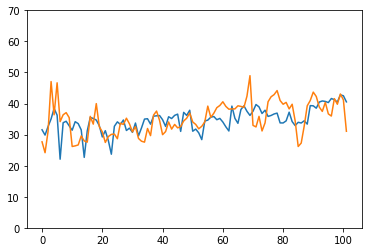

In [7]:
t = range(test_data.shape[0])
plt.ylim(0,70)
plt.plot(t, predict.numpy(), label="predict price")
plt.plot(t, label, label="true price")